In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path as os
from statsmodels.tsa.tsatools import detrend
from scipy.signal import butter, filtfilt, tukey

In [62]:
dual_reg_folder = '/data/pzhutovsky/fMRI_data/Oxytosin_study/analysis/dual_regression_group_biswal2010/'
timecoure_template = 'dr_stage1_subject{:05}.txt'
num_subj = 75
TR = 2.
FS = 1/TR
nyq = 0.5 * FS
N_vol = 238
N_rsn = 20
window_size = 22
window_stepsize = 1
num_windows = np.floor((N_vol - window_size)/window_stepsize + 1).astype(np.int)

### Post-processing (minimal)

In [35]:
data_all_subj = np.zeros((N_vol, N_rsn, num_subj))
b, a = butter(6, 0.15/nyq, btype='lowpass')

for id_sub in xrange(num_subj):
    data_subj = np.loadtxt(osp.join(dual_reg_folder, timecoure_template.format(id_sub)))
    data_subj = detrend(data_subj, axis=0, order=1)
    data_subj = detrend(data_subj, axis=0, order=2)
    data_subj = detrend(data_subj, axis=0, order=3)
    data_subj = filtfilt(b, a, data_subj, axis=0)
    data_subj = (data_subj - data_subj.mean(axis=0, keepdims=True))/data_subj.std(axis=0, keepdims=True)
    
    data_all_subj[..., id_sub] = data_subj

### Windowing

In [44]:
w = tukey(M=window_size)

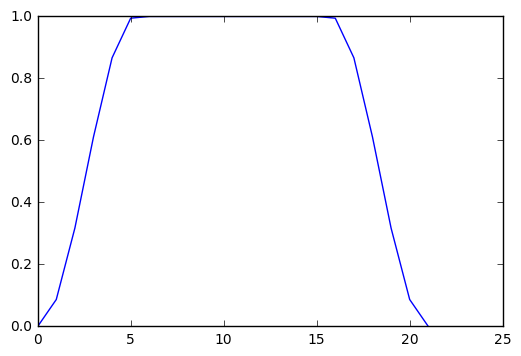

In [45]:
plt.plot(w)

In [76]:
w_broadcasten = w[:, np.newaxis, np.newaxis]

In [77]:
window_timecourses = np.zeros((window_size, num_windows, N_rsn, num_subj))

for i_window in xrange(0, num_windows, window_stepsize):
    window_timecourses[:, i_window, :, :] = data_all_subj[i_window:(i_window + window_size), :, :] * w_broadcasten

In [79]:
window_timecourses.shape

(22, 217, 20, 75)

### GraphLasso

In [86]:
from sklearn.covariance import GraphLassoCV
from sklearn.model_selection import KFold

In [88]:
cv = KFold(n_splits=window_timecourses.shape[1], shuffle=False)

In [103]:
timecourses_concat = window_timecourses.reshape((np.product(window_timecourses.shape[:2]), 
                                                            window_timecourses.shape[2], 
                                                            window_timecourses.shape[3]), order='F')

In [106]:
glasso = GraphLassoCV(alphas=100, cv=cv, n_jobs=10, assume_centered=True)

In [108]:
glasso.fit(timecourses_concat[:, :, 0])

/data/pzhutovsky/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:230: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/data/pzhutovsky/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_lasso_.py:232: RuntimeWarning: invalid value encountered in multiply
  * coefs)
/data/pzhutovsky/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1712: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/data/pzhutovsky/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1712: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/data/pzhutovsky/anaconda2/lib/python2.7/site-packages/numpy/linalg/linalg.py:1712: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/data/pzhutovsky/anaconda2/lib/python2.7/site-packages/sklearn/covariance/graph_

GraphLassoCV(alphas=100, assume_centered=True,
       cv=KFold(n_splits=217, random_state=None, shuffle=False),
       enet_tol=0.0001, max_iter=100, mode='cd', n_jobs=10,
       n_refinements=4, tol=0.0001, verbose=False)

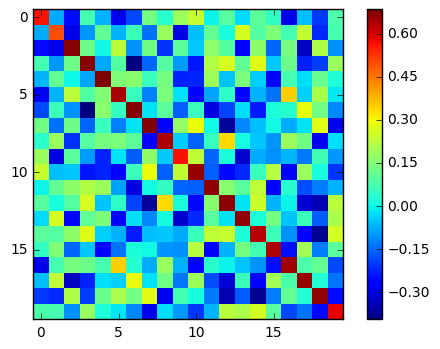

In [113]:
plt.imshow(glasso.covariance_, interpolation='none')
plt.colorbar()

In [122]:
glasso.

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])